In [1]:
!pip3 install --upgrade --quiet google-cloud-aiplatform


In [2]:
!gcloud config list


[compute]
region = us-central1
[core]
account = 390700651009-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = my-second-project88-vm
[dataproc]
region = us-central1

Your active configuration is: [default]


In [3]:
PROJECT_ID = 'my-second-project88-vm'
BUCKET_URI = 'gs://beans-data-bucket'
REGION = 'us-central1'


In [4]:
from google.cloud import aiplatform as ai

ai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)


In [5]:
import pandas as pd

# Path to your CSV file in GCS bucket
gcs_path = "gs://beans-data-bucket/beans.csv"

beans = pd.read_csv(gcs_path)

beans.head()

Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332      0.003147      0.834222      0.998724  SEKER  
1     0.953861      0.006979      0.003564      0.909851      0.998430  SEKER  
2     0.908774      0.007244      0.003048      0.825871      0.999066  SEKER  
3     0.928329      0.007017      0.003215      0.861794      0.994199  SEKER  
4     0.970516      0.006697      0.003665      0.941900      0.999166  SEKER

In [6]:
beans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [7]:
feature_names = beans.columns.tolist()


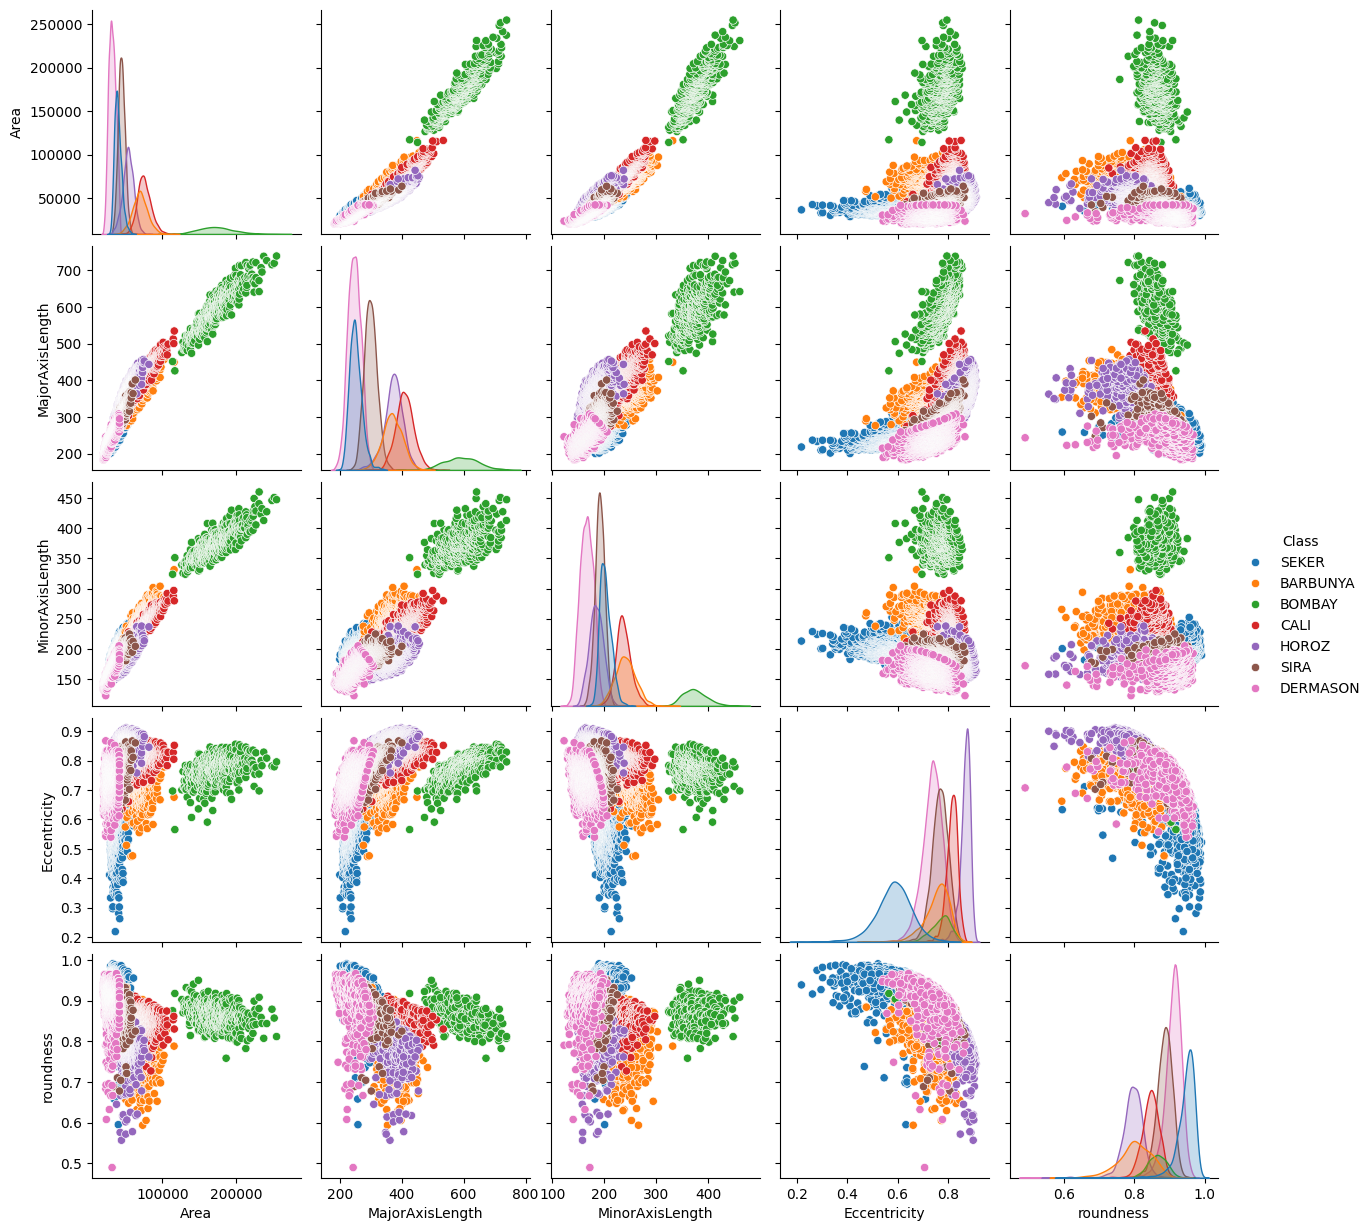

In [8]:
import seaborn as sns

sns.pairplot(
   beans,
   vars=["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "roundness"],
   hue="Class",
);

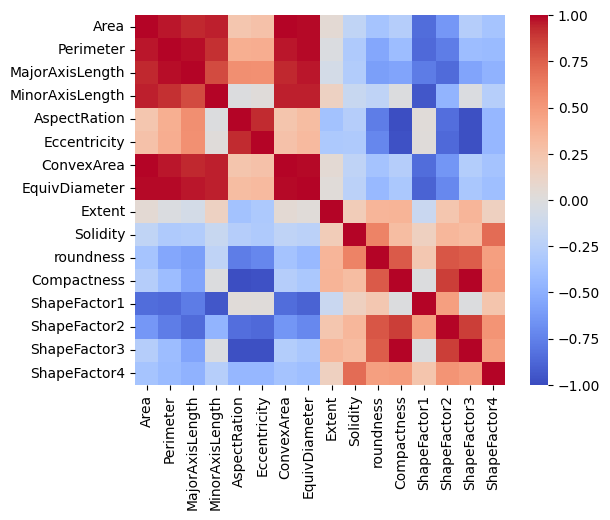

In [9]:
import matplotlib.pyplot as plt

correlation = beans.corr(numeric_only=True)

# Create a square heatmap with center at 0
sns.heatmap(correlation, center=0, square=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.show()


In [10]:
ds = ai.TabularDataset.create(
   display_name="dry_bean_dataset", gcs_source=gcs_path
)


Creating TabularDataset
Create TabularDataset backing LRO: projects/390700651009/locations/us-central1/datasets/7915246219650138112/operations/6929558887439794176
TabularDataset created. Resource name: projects/390700651009/locations/us-central1/datasets/7915246219650138112
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/390700651009/locations/us-central1/datasets/7915246219650138112')


In [11]:
type(ds)

google.cloud.aiplatform.datasets.tabular_dataset.TabularDataset

In [12]:
ds.resource_name


'projects/390700651009/locations/us-central1/datasets/7915246219650138112'

In [13]:
job = ai.AutoMLTabularTrainingJob(
   display_name="dry-bean-classification",
   optimization_prediction_type="classification",
)


In [ ]:
model = job.run(
   dataset=ds,
   target_column="Class",
   training_fraction_split=0.8,
   validation_fraction_split=0.1,
   test_fraction_split=0.1,
   model_display_name="baseline-classification-model",
   disable_early_stopping=False,
)


No column transformations provided, so now retrieving columns from dataset in order to set default column transformations.
The column transformation of type 'auto' was set for the following columns: ['Area', 'Perimeter', 'ConvexArea', 'Solidity', 'ShapeFactor1', 'AspectRation', 'roundness', 'ShapeFactor3', 'Compactness', 'ShapeFactor2', 'Extent', 'MinorAxisLength', 'ShapeFactor4', 'EquivDiameter', 'MajorAxisLength', 'Eccentricity'].
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/1899728236191940608?project=390700651009
AutoMLTabularTrainingJob projects/390700651009/locations/us-central1/trainingPipelines/1899728236191940608 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/390700651009/locations/us-central1/trainingPipelines/1899728236191940608 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/390700651009/locations/us-central1/trainingPipelines/1899728236191940608 curren

In [ ]:
endpoint = model.deploy(machine_type="n1-standard-4")


In [ ]:
prediction = endpoint.predict(
   [
       {
           "Area": "30099",
           "Perimeter": "638.8209999999999",
           "MajorAxisLength": "237.14191130827916",
           "MinorAxisLength": "162.3034300714102",
           "AspectRation": "1.4611022774068396",
           "Eccentricity": "0.7290928631259719",
           "ConvexArea": "30477",
           "EquivDiameter": "195.76321681302556",
           "Extent": "0.8036043251902283",
           "Solidity": "0.9875972044492568",
           "roundness": "0.9268374259664279",
           "Compactness": "0.8255108332939839",
           "ShapeFactor1": "0.007878730566074592",
           "ShapeFactor2": "0.002256976927384019",
           "ShapeFactor3": "0.6814681358857279",
           "ShapeFactor4": "0.9956946453228307",
       }
   ]
)

print(prediction)